In [1]:
%pip install datasets
%pip install transformers
%pip install huggingface_hub
%pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Example: Streaming mode for large datasets
# This loads data on-demand without downloading everything first

from datasets import load_dataset
from tqdm import tqdm
import pandas as pd

# Streaming mode - data is loaded on-demand, not all at once
ds_streaming = load_dataset("allenai/WildChat-1M", split="train", streaming=True)

# Take only the first 1k English-language records for exploration (more memory efficient)
ds_english_stream = ds_streaming.filter(lambda row: row['language'] == 'English')

# We'll collect up to (for example) 2000 records, then dedup, and take the first 1000 unique
max_to_scan = 3000  # oversample to ensure uniqueness amongst 1k rows
ds_candidates = [item for item in tqdm(ds_english_stream.take(max_to_scan), total=max_to_scan, desc=f"Scanning {max_to_scan} English samples")]

ds_df = pd.DataFrame(ds_candidates)
num_duplicates = ds_df.duplicated(subset=['conversation']).sum()

# Drop duplicate 'conversation' rows; keep first occurrence
ds_unique = ds_df.drop_duplicates(subset=['conversation'], keep='first').head(1000)

# Convert back to list-of-dicts for further use
ds = ds_unique.to_dict(orient='records')

print("All rows have 'language' = 'English':", (pd.Series([row['language'] for row in ds]) == "English").all())
print(f"Number of duplicate 'conversation' rows removed in scan: {num_duplicates}")
print(f"Size of deduplicated ds: {len(ds)}")
if len(ds) < 1000:
    print("Warning: Less than 1000 unique conversations found in scanned set!")



Scanning 3000 English samples: 100%|██████████| 3000/3000 [00:06<00:00, 460.29it/s]


All rows have 'language' = 'English': True
Number of duplicate 'conversation' rows removed in scan: 0
Size of deduplicated ds: 1000


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Convert the list of dicts to a DataFrame
df = pd.DataFrame(ds)

# Show all columns (no truncation)
pd.set_option('display.max_columns', None)

# Print the DataFrame columns
print("Columns in the dataset:")
print(df.columns.tolist())
print(f"\nTotal records: {len(df)}")
print("\nFirst few rows:")
print(df.head())

Columns in the dataset:
['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header']

Total records: 1000

First few rows:
                  conversation_hash               model  \
0  c9ec5b440fbdd2a269333dd241f32f64          gpt-4-0314   
1  cf1267ca6b2f6fccc9c36652a00059a1          gpt-4-0314   
2  e98d3e74c57f9a65261df393d9124ac2          gpt-4-0314   
3  2e8fd255aab694b07a0be8d83cb53a7b          gpt-4-0314   
4  59c72510f3143025f94f75b883b026bd  gpt-3.5-turbo-0301   

                  timestamp  \
0 2023-04-09 00:02:53+00:00   
1 2023-04-09 00:04:52+00:00   
2 2023-04-09 00:06:49+00:00   
3 2023-04-09 00:08:41+00:00   
4 2023-04-09 00:10:00+00:00   

                                        conversation  turn language  \
0  [{'content': 'Hey there! Are you familiar with...     1  English   
1  [{'content': 'Old age PT hx of DM, HTN, dyslip...     1  Englis

In [4]:
from collections import defaultdict
# Preprocess data for analysis
# Extract hour of day from timestamp
# Since timestamp is already a pandas Timestamp, we can use .dt.hour directly

# Convert timestamp to datetime if it's not already (should already be Timestamp)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract hour using .dt.hour accessor (vectorized, much faster than apply)
df['hour_of_day'] = df['timestamp'].dt.hour

# Logging content and role for every turn in the conversation.
convs = []
for idx, conv in enumerate(df['conversation']):
    trace_dict = defaultdict(dict)
    for turn in conv:
        # trace_dict[turn_identifier] has 2 keys: role_user and role_assistant
        trace_dict[turn['turn_identifier']][turn['role']] = turn['content']
    convs.append(trace_dict)

df['conversation'] = convs
# Logging the first conversation.
print(f"First conversation: {df['conversation'].iloc[0]}")

# Check for missing values
print("Missing values per column:")
print(df[['model', 'turn', 'hour_of_day', 'state', 'country']].isnull().sum())
print(f"\nTotal records: {len(df)}")
print(f"Records with all required fields: {df[['model', 'turn', 'hour_of_day', 'state', 'country']].notna().all(axis=1).sum()}")
unique_hours = df['hour_of_day'].nunique(dropna=True)
print(f"\nNumber of unique 'hour_of_day' values: {unique_hours}")
print(f"Unique values: {sorted(df['hour_of_day'].dropna().unique())}")


First conversation: defaultdict(<class 'dict'>, {101001: {'user': 'Hey there! Are you familiar with reality shifting? So, I’m refining a foolproof method for reality shifting and want to pick a destination. Want to help me? I’m thinking something pretty personalized. There are a few things that are required of my destination. 1. The quest. I have to have a clear overarching goal in my reality, and don’t make it too crazy. It should be more along the lines of “save the president’s daughter” or “escape this weird wacky sinister place” NOT “get an artifact that literally controls reality”. Seriously, don’t make me fetch an artifact, or fetch anything. Instead, make me DO something. 2. Babes. I need pretty girls. 3. The entry. I need to get to lose consciousness in order to begin my journey in my desired reality, preferably by having it knocked out by one of the aforementioned babes. 4. Action. It needs to be cool. 5. Unconsciousness. Myself and the babes need to pass out in this place, pr

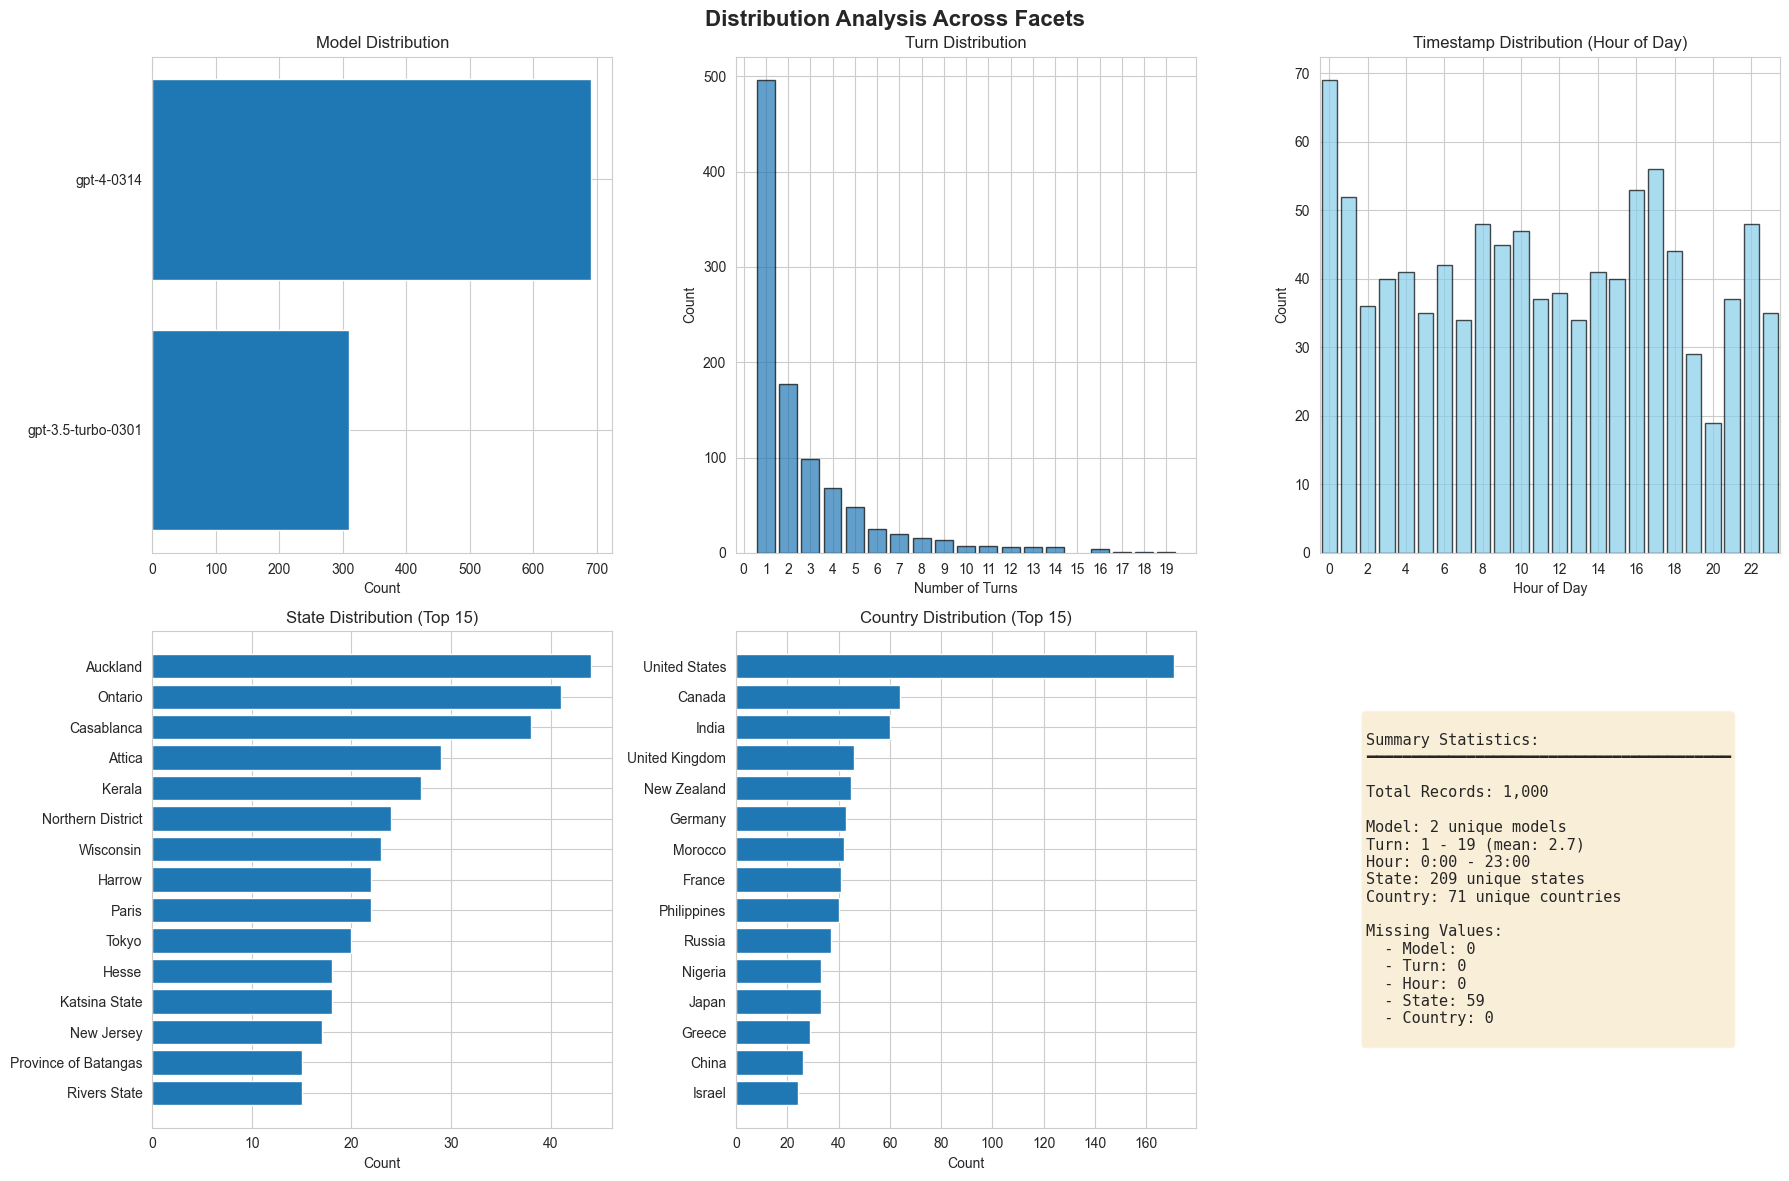


TOP VALUES FOR EACH FACET

📊 Top 10 Models:
model
gpt-4-0314            690
gpt-3.5-turbo-0301    310
Name: count, dtype: int64

📊 Top 10 Turn Values:
turn
1     496
2     177
3      98
4      68
5      48
6      25
7      20
8      16
9      13
10      7
Name: count, dtype: int64

📊 Hour Distribution (Top 10):
hour_of_day
0     69
17    56
16    53
1     52
22    48
8     48
10    47
9     45
18    44
6     42
Name: count, dtype: int64

📊 Top 10 States:
state
Auckland             44
Ontario              41
Casablanca           38
Attica               29
Kerala               27
Northern District    24
Wisconsin            23
Harrow               22
Paris                22
Tokyo                20
Name: count, dtype: int64

📊 Top 10 Countries:
country
United States     171
Canada             64
India              60
United Kingdom     46
New Zealand        45
Germany            43
Morocco            42
France             41
Philippines        40
Russia             37
Name: count, dtype:

In [5]:
# Create distribution visualizations for each facet
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution Analysis Across Facets', fontsize=16, fontweight='bold')

# 1. Model distribution
ax1 = axes[0, 0]
model_counts = df['model'].value_counts()
if len(model_counts) > 20:
    # Show top 20 if too many models
    model_counts = model_counts.head(20)
    ax1.barh(range(len(model_counts)), model_counts.values)
    ax1.set_yticks(range(len(model_counts)))
    ax1.set_yticklabels(model_counts.index)
    ax1.set_xlabel('Count')
    ax1.set_title(f'Model Distribution (Top 20)')
else:
    ax1.barh(range(len(model_counts)), model_counts.values)
    ax1.set_yticks(range(len(model_counts)))
    ax1.set_yticklabels(model_counts.index)
    ax1.set_xlabel('Count')
    ax1.set_title('Model Distribution')
ax1.invert_yaxis()

# 2. Turn (#turns) distribution
ax2 = axes[0, 1]
turn_counts = df['turn'].value_counts().sort_index()
ax2.bar(turn_counts.index, turn_counts.values, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Number of Turns')
ax2.set_ylabel('Count')
ax2.set_title('Turn Distribution')
ax2.set_xticks(range(0, int(turn_counts.index.max()) + 1, max(1, int(turn_counts.index.max()) // 10)))

# 3. Time of day (hour) distribution
ax3 = axes[0, 2]
hour_counts = df['hour_of_day'].dropna().value_counts().sort_index()
ax3.bar(hour_counts.index, hour_counts.values, edgecolor='black', alpha=0.7, color='skyblue')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Count')
ax3.set_title('Timestamp Distribution (Hour of Day)')
ax3.set_xticks(range(0, 24, 2))
ax3.set_xlim(-0.5, 23.5)

# 4. State distribution
ax4 = axes[1, 0]
state_counts = df['state'].dropna().value_counts()
if len(state_counts) > 15:
    # Show top 15 if too many states
    state_counts = state_counts.head(15)
    ax4.barh(range(len(state_counts)), state_counts.values)
    ax4.set_yticks(range(len(state_counts)))
    ax4.set_yticklabels(state_counts.index)
    ax4.set_xlabel('Count')
    ax4.set_title(f'State Distribution (Top 15)')
else:
    ax4.barh(range(len(state_counts)), state_counts.values)
    ax4.set_yticks(range(len(state_counts)))
    ax4.set_yticklabels(state_counts.index)
    ax4.set_xlabel('Count')
    ax4.set_title('State Distribution')
ax4.invert_yaxis()

# 5. Country distribution
ax5 = axes[1, 1]
country_counts = df['country'].dropna().value_counts()
if len(country_counts) > 15:
    # Show top 15 if too many countries
    country_counts = country_counts.head(15)
    ax5.barh(range(len(country_counts)), country_counts.values)
    ax5.set_yticks(range(len(country_counts)))
    ax5.set_yticklabels(country_counts.index)
    ax5.set_xlabel('Count')
    ax5.set_title(f'Country Distribution (Top 15)')
else:
    ax5.barh(range(len(country_counts)), country_counts.values)
    ax5.set_yticks(range(len(country_counts)))
    ax5.set_yticklabels(country_counts.index)
    ax5.set_xlabel('Count')
    ax5.set_title('Country Distribution')
ax5.invert_yaxis()

# 6. Summary statistics
ax6 = axes[1, 2]
ax6.axis('off')
summary_text = f"""
Summary Statistics:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Total Records: {len(df):,}

Model: {df['model'].nunique()} unique models
Turn: {df['turn'].min():.0f} - {df['turn'].max():.0f} (mean: {df['turn'].mean():.1f})
Hour: {df['hour_of_day'].min():.0f}:00 - {df['hour_of_day'].max():.0f}:00
State: {df['state'].nunique()} unique states
Country: {df['country'].nunique()} unique countries

Missing Values:
  - Model: {df['model'].isnull().sum()}
  - Turn: {df['turn'].isnull().sum()}
  - Hour: {df['hour_of_day'].isnull().sum()}
  - State: {df['state'].isnull().sum()}
  - Country: {df['country'].isnull().sum()}
"""
ax6.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print top values for each facet
print("\n" + "="*60)
print("TOP VALUES FOR EACH FACET")
print("="*60)
print("\n📊 Top 10 Models:")
print(df['model'].value_counts().head(10))
print("\n📊 Top 10 Turn Values:")
print(df['turn'].value_counts().head(10))
print("\n📊 Hour Distribution (Top 10):")
print(df['hour_of_day'].value_counts().head(10))
print("\n📊 Top 10 States:")
print(df['state'].value_counts().head(10))
print("\n📊 Top 10 Countries:")
print(df['country'].value_counts().head(10))


In [6]:
df.head()

,conversation_hash,model,timestamp,conversation,turn,language,openai_moderation,detoxify_moderation,toxic,redacted,state,country,hashed_ip,header,hour_of_day
0,c9ec5b440fbdd2a269333dd241f32f64,gpt-4-0314,2023-04-09 00:02:53+00:00,{101001: {'user': 'Hey there! Are you familiar...,1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.00020589135237969458, '...",False,False,Texas,United States,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,"{'accept-language': 'en-US,en;q=0.9,es;q=0.8',...",0
1,cf1267ca6b2f6fccc9c36652a00059a1,gpt-4-0314,2023-04-09 00:04:52+00:00,"{101004: {'user': 'Old age PT hx of DM, HTN, d...",1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.0002258022577734664, 'i...",False,False,Mecca Region,Saudi Arabia,8133108d1c433c180c6be8302dc5a6681f2bec980190a1...,"{'accept-language': 'en-US,en;q=0.9', 'user-ag...",0
2,e98d3e74c57f9a65261df393d9124ac2,gpt-4-0314,2023-04-09 00:06:49+00:00,{101008: {'user': 'Hey there! Are you familiar...,1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.00020642601884901524, '...",False,False,Texas,United States,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,"{'accept-language': 'en-US,en;q=0.9,es;q=0.8',...",0
3,2e8fd255aab694b07a0be8d83cb53a7b,gpt-4-0314,2023-04-09 00:08:41+00:00,{101012: {'user': 'Hey there! Are you familiar...,1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.00020836590556427836, '...",False,False,Texas,United States,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,"{'accept-language': 'en-US,en;q=0.9,es;q=0.8',...",0
4,59c72510f3143025f94f75b883b026bd,gpt-3.5-turbo-0301,2023-04-09 00:10:00+00:00,{101015: {'user': 'i wanna you to write me ter...,1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.0007317529525607824, 'i...",False,False,Giza,Egypt,dbf18c49cf217bc344a40b187ed35c3219f994b1d3b2d0...,"{'accept-language': 'en-US,en;q=0.9', 'user-ag...",0


In [7]:
# Create a new dataframe with the specified columns and standardized column names
selected_columns = {
    'model': 'Model',
    'conversation': 'Conversation',
    'language': 'Language',
    'toxic': 'Toxic',
    'state': 'State',
    'country': 'Country',
    'hour_of_day': 'Hour of Day'
}
df_selected = df[list(selected_columns.keys())].rename(columns=selected_columns)


In [8]:
# Creating a new column for the LLM-generated topic/facet and its embedding
df_selected['Topic'] = ''
df_selected['Topic_Embedding'] = ''

In [ ]:
df_selected.head()

,Model,Conversation,Language,Toxic,State,Country,Hour of Day,Topic,Topic_Embedding
0,gpt-4-0314,{101001: {'user': 'Hey there! Are you familiar...,English,False,Texas,United States,0,,
1,gpt-4-0314,"{101004: {'user': 'Old age PT hx of DM, HTN, d...",English,False,Mecca Region,Saudi Arabia,0,,
2,gpt-4-0314,{101008: {'user': 'Hey there! Are you familiar...,English,False,Texas,United States,0,,
3,gpt-4-0314,{101012: {'user': 'Hey there! Are you familiar...,English,False,Texas,United States,0,,
4,gpt-3.5-turbo-0301,{101015: {'user': 'i wanna you to write me ter...,English,False,Giza,Egypt,0,,


In [10]:
df_selected.to_csv('selected_conversations.csv', index=False)